In [469]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math
import json
from scipy import stats
from pathlib import Path
from statistics import mean
from collections import Counter

import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
# plt.rc('font', family='Times New Roman')

# # plot set start
palette = sns.color_palette("tab10")
# sns.set_theme(font='Times New Roman', font_scale=1.5)
# sns.set_style("white")

In [470]:
def separateAllExp11(expDir: Path):
    results = []
    for dirPath in expDir.glob('*'):
        print(dirPath)
        
        idParas = dirPath.name.split('_slvr')
        id = idParas[0]
        
        solverNameParas = idParas[-1].split('_ds')
        solverName = solverNameParas[0]
        
        downsampleParas = solverNameParas[-1].split('_L')
        downsample = downsampleParas[0]
        
        LSizeParas = downsampleParas[-1].split('_k')
        LSize = LSizeParas[0]
        
        kmaxParas = LSizeParas[-1].split('_ch')
        kmax = kmaxParas[0]
        # print(kmax)

        chunkSizeParas = kmaxParas[-1].split('_r')
        chunkSize = chunkSizeParas[0]
        
        rrParas = chunkSizeParas[-1].split('_thr')
        rr = rrParas[0]

        # threshold_coverageParas = rrParas[-1].split('_pose')
        threshold_coverage = rrParas[1]

        filePara = [id,solverName,downsample,LSize,kmax,chunkSize,rr,threshold_coverage]
        
        numOfFile = len([i for i in (dirPath/'results').glob('*')])   

        for fileNum in range(numOfFile):
            result = []  
            filePath = dirPath/'results'/f'log_{fileNum}.json'
            with open(filePath) as f:
                data = json.load(f)
            
            numOfSourceViews = len(data['sol'])
            numOfCamera = Counter(data['sol']).get(1.0)
            if numOfCamera == None:
                numOfCamera = 0

            for tvNum in range(numOfSourceViews):
                coverage_estimated_first_order_diff = data['coverage_estimated_first_order_diff'][tvNum]
                coverage_estimated_second_order_diff = data['coverage_estimated_second_order_diff'][tvNum]
                result = filePara + [fileNum, numOfSourceViews, numOfCamera, tvNum, coverage_estimated_first_order_diff, coverage_estimated_second_order_diff]
                results.append(result)

    allDf = pd.DataFrame(results)
    allDf.to_csv(f'{expDir.stem}_allResults.csv', header=['id','solverName','downsample','LSize','kmax','chunkSize','rr','threshold_coverage','fileNum','numOfSourceViews','numOfCamera','tvNum','coverage_estimated_first_order_diff','coverage_estimated_second_order_diff'],index=None)

In [471]:
def calSum(arr: list):
    sum = 0
    for i in arr:
        sum = sum + abs(float(i))
    return sum

In [472]:
def MSEPlot(filePath: Path):
    '''
    Get all the average result value from different id
    '''
    doplot = True
    expName = filePath.stem.split('_allResults')[0]
    savePath = Path(f'./img/MSEPlot')
    
    df = pd.read_csv(filePath)
    resultDf = df
    resultDf['coverage_estimated_first_order_diff'] = resultDf['coverage_estimated_first_order_diff'].mul(resultDf['coverage_estimated_first_order_diff'])
    resultDf['coverage_estimated_second_order_diff'] = resultDf['coverage_estimated_second_order_diff'].mul(resultDf['coverage_estimated_second_order_diff'])
    
        
    # first order
    ax = sns.lineplot(x='numOfCamera', y=f'coverage_estimated_first_order_diff', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=7))
    ax.set(xlabel="numOfCamera", ylabel=f"First Order MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_firstOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()


    # second order
    ax = sns.lineplot(x='numOfCamera', y=f'coverage_estimated_second_order_diff', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=7))
    ax.set(xlabel="numOfCamera", ylabel=f"Second Order MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_secondOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

In [473]:
def allCoverageResultAverage(filePath: Path):
    '''
    Get all the average result value from different id
    '''
    expName = filePath.stem.split('_allResults')[0]
    
    doplot = True

    df = pd.read_csv(filePath)
    resultDf = df

    savePath = Path(f'./img/allCoverageResultAverage')

    # first order
    ax = sns.barplot(x='kmax', y=f'averageFirstOrderDiff', data=resultDf, palette=palette)
    ax.set(xlabel="kmax", ylabel=f"First Order Difference")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_firstOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # second order
    ax = sns.barplot(x='kmax', y=f'averageSecondOrderDiff', data=resultDf, palette=palette)
    ax.set(xlabel="kmax", ylabel=f"Second Order Difference")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_secondOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()


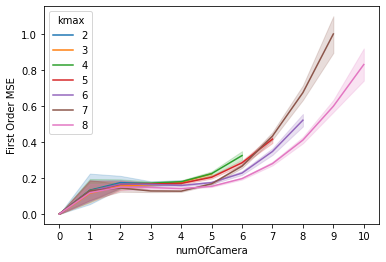

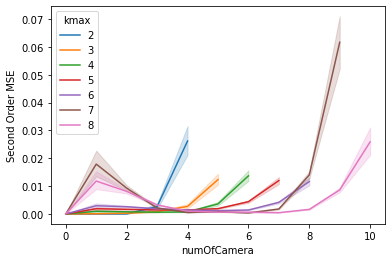

In [474]:
if __name__ == '__main__':
    # resultFilePath = Path('.')/'exp11'
    # separateAllExp11(resultFilePath)
    
    # allResultFilePathGen = Path('.').glob('*_allResults.csv')
    # allCoverageResultAverage(allResultFilePath)
    
    allResultFilePath = Path('./exp11_allResults.csv')
    MSEPlot(allResultFilePath)